In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#base_dir = 'content/drive/MyDrive/Brian_tumor_classification'
import os
os.chdir('/content/drive/MyDrive/Brain_tumor_classification')

#Custom CNN

In [2]:
!pwd

/content


In [ ]:
# !mkdir brain_tumor_dataset

In [ ]:
# !ls

In [ ]:
# !unzip brain_tumor_dataset.zip -d brain_tumor_dataset/

In [ ]:
! ls

brain_tumor_dataset	 graph	      logs   saved_model
brain_tumor_dataset.zip  kaggle.json  saved


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
import PIL
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, activations
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, RandomZoom, RandomFlip, RandomRotation, RandomContrast
from keras.models import Sequential
import datetime
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

In [22]:
data_dir = '/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_dataset/'
data_dir

'/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_dataset/'

In [23]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir  

PosixPath('/content/drive/MyDrive/Brain_tumor_classification/brain_tumor_dataset')

In [24]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
image_count

7023

In [21]:
glioma_tumor = list(data_dir.glob('*/glioma/*'))
glioma_tumor[:5]

[]

In [15]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [25]:
X = [] #Training Dataset
y = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join(data_dir, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        y.append(i)
        
        
for i in labels:
    folderPath = os.path.join(data_dir, 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        y.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X = np.array(X)
y = np.array(y)

100%|██████████| 300/300 [00:04<00:00, 63.74it/s] 


In [26]:
X.shape

(7023, 150, 150, 3)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=142)

In [28]:
X_train.shape

(6320, 150, 150, 3)

In [29]:
X_test.shape

(703, 150, 150, 3)

In [30]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [31]:
X_train.shape

(6320, 150, 150, 3)

In [32]:
y_test.shape

(703, 4)

In [33]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [34]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(150, 150, 3)),
    tf.keras.layers.RandomRotation(0.2, fill_mode='reflect'),
    tf.keras.layers.RandomContrast(0.2),
  ]
)

In [ ]:
#original
num_classes = 4

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    Conv2D(64, 3, padding='same', activation= 'relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(64, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(256, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(512, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.3),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(64, activation= 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation= 'softmax')
])

model.build(input_shape=(None,150,150,3))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)    

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
              
history = model.fit(X_train,
                     y_train, 
                     validation_data=(X_test, y_test),
                     epochs=40,
                     batch_size= 32)

In [36]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/CNN')
import pickle
import time

f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

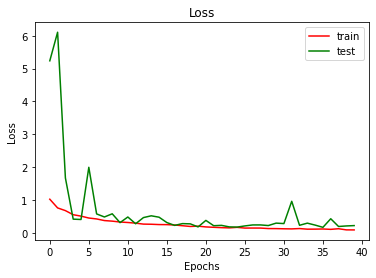

In [37]:
#model 1
plt.plot(history["loss"],c = "red")
plt.plot(history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

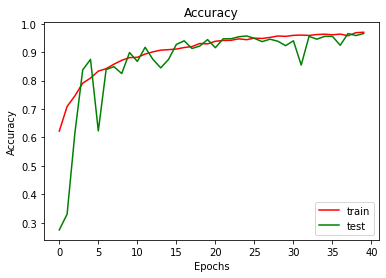

In [38]:
#model1
plt.plot(history["accuracy"],c = "red")
plt.plot(history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# Getting model predictions model2

test_predictions = model.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

In [ ]:
#model2

cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
!mkdir saved

In [ ]:
!pwd

/content/drive/MyDrive/Brain_tumor_classification


In [ ]:
# model = tf.keras.models.load_model('content/drive/MyDrive/Brain/saved_model/CCNN.h5')
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/saved/')
!ls

In [ ]:
# from keras.models import save
model.save("CNN.h5", save_format="h5")


In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/') 

In [ ]:
!mkdir graph

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph')

In [ ]:
!mkdir CNN

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/CNN')
import pickle
import time

In [ ]:
!ls

history.pckl


In [ ]:

import pickle


f = open('history.pckl', 'wb')
history = pickle.dump(history, f)
f.close()

In [ ]:
# model = tf.keras.models.load_model('content/drive/MyDrive/Brain/saved_model/CCNN.h5')
os.chdir('/content/drive/MyDrive/Brain/saved_model/')
!ls

CCNN  CNN  CNN2  Final_CNN  mobilenet


In [ ]:
from keras.models import load_model
model = load_model('CCNN')

#for model's summary and details.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)       

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/CCNN')
import pickle

f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [ ]:
#model 1
plt.plot(history["loss"],c = "red")
plt.plot(history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
#model1
plt.plot(history["accuracy"],c = "red")
plt.plot(history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# Getting model predictions model2

test_predictions = model.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       159
           1       0.98      0.91      0.94       158
           2       0.98      0.99      0.99       193
           3       0.96      0.99      0.98       193

    accuracy                           0.97       703
   macro avg       0.97      0.97      0.97       703
weighted avg       0.97      0.97      0.97       703



In [ ]:
#model2

cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
# model2.save('saved_model/CCNN', save_format='h5')

#VGG-16

In [ ]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    # tf.keras.layers.RandomRotation(0.2, fill_mode='reflect'),
  ]
)

In [ ]:
base_model = keras.applications.VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

model2 = Sequential()
model2.add(resize_and_rescale)
model2.add(data_augmentation)
model2.add(keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='softmax'))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model2.build(input_shape=(None,IMG_SIZE,IMG_SIZE,3))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)              

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
              
history2 = model2.fit(X_train,
                     y_train, 
                     validation_data=(X_test, y_test),
                     epochs=40,
                     batch_size= 32)

Epoch 1/40


198/198 [==============================] - 78s 333ms/step - loss: 0.8620 - accuracy: 0.7160 - val_loss: 0.3719 - val_accuracy: 0.8336
Epoch 2/40
198/198 [==============================] - 59s 296ms/step - loss: 0.4644 - accuracy: 0.8217 - val_loss: 0.3154 - val_accuracy: 0.9047
Epoch 3/40
198/198 [==============================] - 57s 289ms/step - loss: 0.4047 - accuracy: 0.8487 - val_loss: 0.2555 - val_accuracy: 0.9047
Epoch 4/40
198/198 [==============================] - 57s 290ms/step - loss: 0.3800 - accuracy: 0.8597 - val_loss: 0.2311 - val_accuracy: 0.9218
Epoch 5/40
198/198 [==============================] - 58s 292ms/step - loss: 0.3415 - accuracy: 0.8710 - val_loss: 0.2382 - val_accuracy: 0.9118
Epoch 6/40
198/198 [==============================] - 57s 289ms/step - loss: 0.3194 - accuracy: 0.8790 - val_loss: 0.2285 - val_accuracy: 0.9218
Epoch 7/40
198/198 [==============================] - 57s 290ms/step - loss: 0.3027 - accuracy: 0.8826 - val_loss: 0.2597 - val_accuracy: 0.9

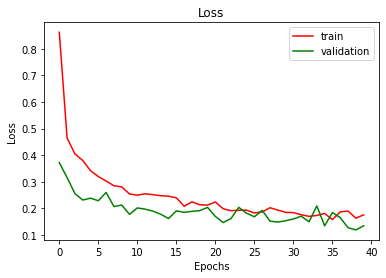

In [ ]:
plt.plot(history2.history["loss"],c = "red")
plt.plot(history2.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

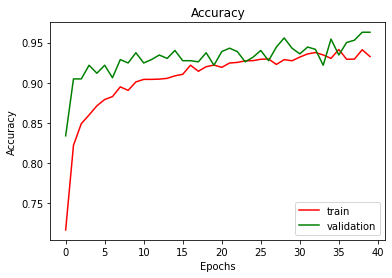

In [ ]:
plt.plot(history2.history["accuracy"],c = "red")
plt.plot(history2.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

In [ ]:
test_predictions = model2.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 4s 165ms/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       159
           1       0.89      0.99      0.93       158
           2       1.00      0.99      0.99       193
           3       0.98      0.99      0.98       193

    accuracy                           0.96       703
   macro avg       0.96      0.96      0.96       703
weighted avg       0.97      0.96      0.96       703



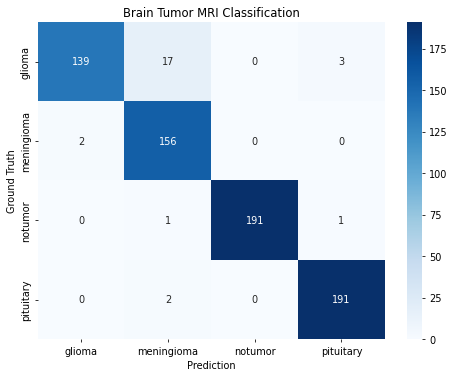

In [ ]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph')
# !mkdir VGG16
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/VGG16')
import pickle

f = open('history2.pckl', 'wb')
history2 = pickle.dump(history2.history, f)
f.close()

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/saved/')
!ls

CNN.h5	MobileNetv2.h5	ResNet50.h5  VGG16.h5


In [ ]:
model2.save('VGG16.h5', save_format='h5')

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/VGG16/')
import pickle

f = open('history2.pckl', 'rb')
history2 = pickle.load(f)
f.close()

In [ ]:
history2['accuracy']

[0.7159810066223145,
 0.8216772079467773,
 0.8487342000007629,
 0.8596519231796265,
 0.8710442781448364,
 0.8789557218551636,
 0.8825949430465698,
 0.8947784900665283,
 0.8903480768203735,
 0.9009493589401245,
 0.9041139483451843,
 0.9041139483451843,
 0.9044303894042969,
 0.9053797721862793,
 0.9085443019866943,
 0.9104430675506592,
 0.9218354225158691,
 0.9142404794692993,
 0.9199367165565491,
 0.9219936728477478,
 0.9191455841064453,
 0.9245253205299377,
 0.9253164529800415,
 0.9272152185440063,
 0.9275316596031189,
 0.9292721748352051,
 0.9295886158943176,
 0.9227848052978516,
 0.9287974834442139,
 0.9273734092712402,
 0.9319620132446289,
 0.9359177350997925,
 0.9376582503318787,
 0.9346519112586975,
 0.9303797483444214,
 0.9414557218551636,
 0.9292721748352051,
 0.929430365562439,
 0.9411392211914062,
 0.9325949549674988]

#MobileNetV2

In [ ]:
# MobileNet
base_model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# # Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

model3 = Sequential()
model3.add(resize_and_rescale)
model3.add(data_augmentation)
model3.add(keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)))
model3.add(base_model)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.2))

model3.add(Dense(4, activation='softmax'))

model3.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model3.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                         

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
              
history3 = model3.fit(X_train,
                     y_train, 
                     validation_data=(X_test, y_test),
                     epochs=40,
                     batch_size= 32)

Epoch 1/40


198/198 [==============================] - 41s 169ms/step - loss: 0.6253 - accuracy: 0.7634 - val_loss: 0.4177 - val_accuracy: 0.8435
Epoch 2/40
198/198 [==============================] - 33s 168ms/step - loss: 0.4145 - accuracy: 0.8464 - val_loss: 0.3995 - val_accuracy: 0.8336
Epoch 3/40
198/198 [==============================] - 32s 163ms/step - loss: 0.3712 - accuracy: 0.8619 - val_loss: 0.3323 - val_accuracy: 0.8691
Epoch 4/40
198/198 [==============================] - 32s 163ms/step - loss: 0.3448 - accuracy: 0.8720 - val_loss: 0.3794 - val_accuracy: 0.8606
Epoch 5/40
198/198 [==============================] - 32s 162ms/step - loss: 0.3356 - accuracy: 0.8747 - val_loss: 0.3073 - val_accuracy: 0.8805
Epoch 6/40
198/198 [==============================] - 32s 160ms/step - loss: 0.3110 - accuracy: 0.8837 - val_loss: 0.2965 - val_accuracy: 0.8876
Epoch 7/40
198/198 [==============================] - 32s 162ms/step - loss: 0.3000 - accuracy: 0.8862 - val_loss: 0.3286 - val_accuracy: 0.8

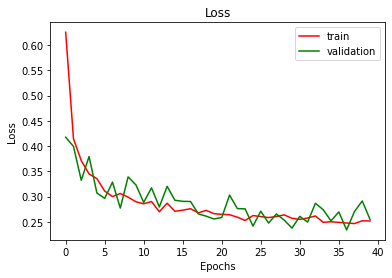

In [ ]:
plt.plot(history3.history["loss"],c = "red")
plt.plot(history3.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

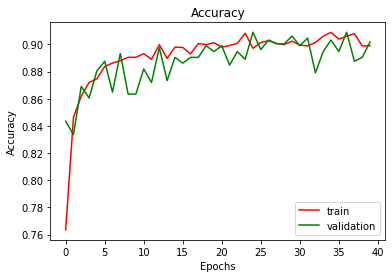

In [ ]:
plt.plot(history3.history["accuracy"],c = "red")
plt.plot(history3.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

In [ ]:
test_predictions = model3.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       159
           1       0.84      0.78      0.81       158
           2       0.99      0.95      0.97       193
           3       0.89      1.00      0.94       193

    accuracy                           0.90       703
   macro avg       0.90      0.89      0.89       703
weighted avg       0.90      0.90      0.90       703



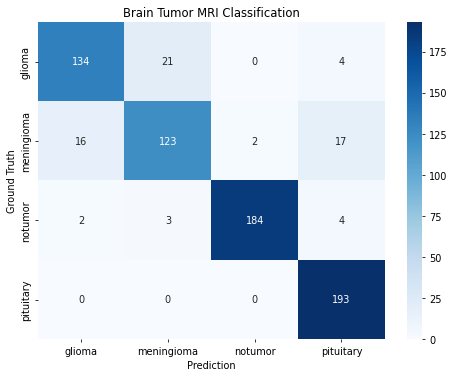

In [ ]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

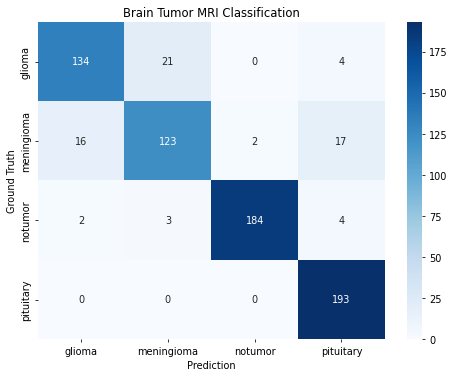

In [ ]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph')
# !mkdir MobileNet
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/MobileNet')
import pickle

# f = open('history3.pckl', 'wb')
# history3 = pickle.dump(history3.history, f)
# f.close()

f = open('history3.pckl', 'rb')
history3 = pickle.load(f)
f.close()

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/saved/')
!ls

CNN.h5	MobileNetv2.h5	ResNet50.h5  VGG16.h5


In [ ]:
model3.save('MobileNetv2.h5', save_format='h5')

#ResNet50

In [ ]:
# MobileNet
base_model = keras.applications.resnet50.ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

model4 = Sequential()
model4.add(resize_and_rescale)
model4.add(data_augmentation)
model4.add(keras.Input(shape=(IMG_SIZE,IMG_SIZE,3)))
model4.add(base_model)
model4.add(GlobalAveragePooling2D())
model4.add(Dense((1024), activation='relu'))
model4.add(Dense(4, activation='softmax'))

model4.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 input_10 (InputLayer)       multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              2098176   
                                                     

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
              
history4 = model4.fit(X_train,
                     y_train, 
                     validation_data=(X_test, y_test),
                     epochs=40,
                     batch_size= 32)

Epoch 1/40
198/198 [==============================] - 28s 121ms/step - loss: 1.1295 - accuracy: 0.5302 - val_loss: 1.0412 - val_accuracy: 0.4979
Epoch 2/40
198/198 [==============================] - 23s 115ms/step - loss: 0.8783 - accuracy: 0.6378 - val_loss: 0.7853 - val_accuracy: 0.6657
Epoch 3/40
198/198 [==============================] - 23s 115ms/step - loss: 0.7733 - accuracy: 0.6883 - val_loss: 0.7207 - val_accuracy: 0.7155
Epoch 4/40
198/198 [==============================] - 23s 118ms/step - loss: 0.7419 - accuracy: 0.6973 - val_loss: 0.7034 - val_accuracy: 0.7198
Epoch 5/40
198/198 [==============================] - 23s 115ms/step - loss: 0.7039 - accuracy: 0.7134 - val_loss: 0.6882 - val_accuracy: 0.6984
Epoch 6/40
198/198 [==============================] - 23s 116ms/step - loss: 0.6687 - accuracy: 0.7282 - val_loss: 0.5824 - val_accuracy: 0.7738
Epoch 7/40
198/198 [==============================] - 23s 115ms/step - loss: 0.6581 - accuracy: 0.7339 - val_loss: 0.6183 - val_ac

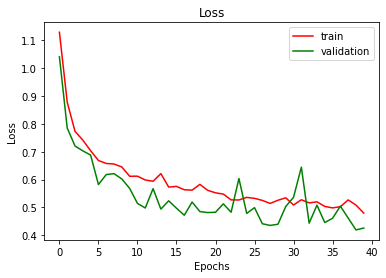

In [ ]:
plt.plot(history4.history["loss"],c = "red")
plt.plot(history4.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

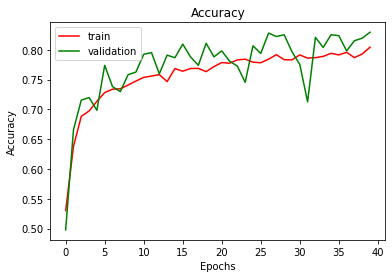

In [ ]:
plt.plot(history4.history["accuracy"],c = "red")
plt.plot(history4.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

In [ ]:
test_predictions = model4.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 3s 89ms/step
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       159
           1       0.69      0.68      0.68       158
           2       0.90      0.98      0.94       193
           3       0.94      0.92      0.93       193

    accuracy                           0.83       703
   macro avg       0.82      0.82      0.82       703
weighted avg       0.83      0.83      0.83       703



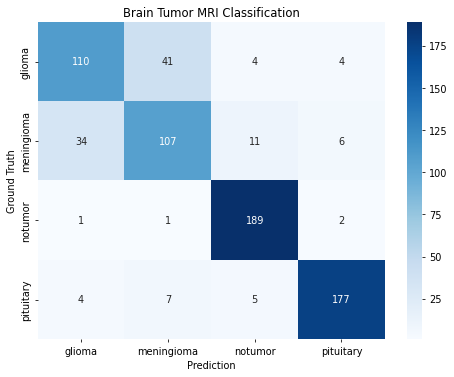

In [ ]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph')
# !mkdir ResNet50
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/ResNet50')
import pickle

# f = open('history4.pckl', 'wb')
# history4 = pickle.dump(history4.history, f)
# f.close()

f = open('history4.pckl', 'rb')
history4 = pickle.load(f)
f.close()

mkdir: cannot create directory ‘ResNet50’: File exists


In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/saved/')
!ls

CNN.h5	MobileNetv2.h5	ResNet50.h5  VGG16.h5


In [ ]:
model4.save('ResNet50.h5', save_format='h5')

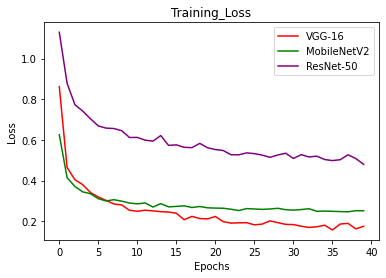

In [ ]:
plt.plot(history2["loss"],c = "red")
plt.plot(history3["loss"],c = "green")
plt.plot(history4["loss"],c = "purple")
plt.title("Training_Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["VGG-16", "MobileNetV2", "ResNet-50"])
plt.show()

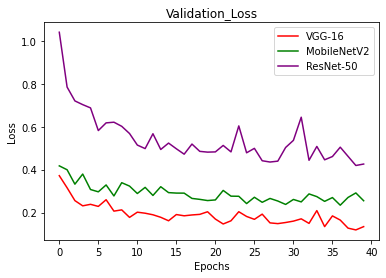

In [ ]:
plt.plot(history2["val_loss"],c = "red")
plt.plot(history3["val_loss"],c = "green")
plt.plot(history4["val_loss"],c = "purple")
plt.title("Validation_Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["VGG-16", "MobileNetV2", "ResNet-50"])
plt.show()

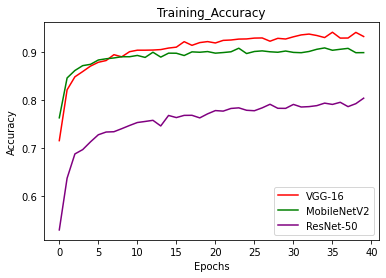

In [ ]:
plt.plot(history2["accuracy"],c = "red")
plt.plot(history3["accuracy"],c = "green")
plt.plot(history4["accuracy"],c = "purple")
plt.title("Training_Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["VGG-16", "MobileNetV2", "ResNet-50"])
plt.show()

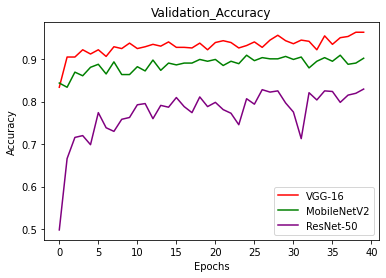

In [ ]:
plt.plot(history2["val_accuracy"],c = "red")
plt.plot(history3["val_accuracy"],c = "green")
plt.plot(history4["val_accuracy"],c = "purple")
plt.title("Validation_Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["VGG-16", "MobileNetV2", "ResNet-50"])
plt.show()